# Projective representation gradient descent test
Created 22/10/2024

Objectives:
* Apply algorithm from "proj_rep_gradient_descent_test" notebook to find projective representation unitaries across a range of cases, and hence extract SPT phase.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [4]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
NUM_SITES = 6

In [18]:
e, a, b, c = symmetry_labels

In [19]:
group_products = [
    (a, a, e),
    (b, b, e),
    (c, c, e),
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

## Functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [28]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [29]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [30]:
def unitarity_gradient(matrix, grouped_physical_leg_label='p',
                      grouped_physical_leg_conj_label='p*'):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())

    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [31]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [32]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(overlap)

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

### Proj rep functions

In [33]:
IDENTITY_LABEL = 'II'

In [34]:
def update_grad_dict(grad_dict, group_element_label, value):
    if group_element_label in grad_dict:
        grad_dict[group_element_label] += value
    else:
        grad_dict[group_element_label] = value

In [35]:
def get_unitary_from_dict(unitary_dict, label, identity_label=IDENTITY_LABEL):
    if label == identity_label:
        return None
    else:
        return unitary_dict[label]

In [36]:
def update_grad_inverse_pair_case(unitary_1, unitary_2, group_label_1,
                               group_label_2, matrix_mul, grad_dict,
                               scores_dict, identity_label=IDENTITY_LABEL):
    u1, u2 = unitary_1, unitary_2
    
    u3 = matrix_mul(u1, u2)

    leg_labels = u3.get_leg_labels()

    c = npc.trace(u3, *leg_labels)
    c_normed = c/(np.abs(c))

    o1 = matrix_mul(u3, u2.conj())
    o2 = matrix_mul(u1.conj(), u3)

    grad_1 = o1 - c_normed*(u2.conj())
    grad_2 = o2 - c_normed*(u1.conj())

    update_grad_dict(grad_dict, group_label_1, grad_1)
    update_grad_dict(grad_dict, group_label_2, grad_2)

    s1 = npc.tensordot(o1, u1.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u3.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[(group_label_1, group_label_2, identity_label)] = score

In [37]:
def update_grad_generic_case(unitary_triple, group_label_triple, matrix_mul,
                          grad_dict, scores_dict):
    
    u_a, u_b, u_c = unitary_triple

    # Perform matrix multiplications in a way that's difficult to read but
    # ultimately reduces the number of matrix multiplications performed.
    u1 = matrix_mul(u_a, u_b)
    u2 = matrix_mul(u_a.conj(), u_c)
    u3 = matrix_mul(u_c, u_b.conj())

    u_triple = matrix_mul(u1, u_c.conj())
    u4 = matrix_mul(u_triple, u3)
    u5 = matrix_mul(u_a.conj(), u1)
    u6 = reduce(matrix_mul, [u5, u_c.conj(), u_c])
    u7 = matrix_mul(u3, u5)

    leg_labels = u_triple.get_leg_labels()

    c = npc.trace(u_triple, *leg_labels)
    c_normed = c/(np.abs(c))

    grads = [
        u4 - c_normed*u3,
        u6 - c_normed*u2,
        u7 - c_normed.conjugate()*u1
    ]

    for l, g in zip(group_label_triple, grads):
        update_grad_dict(grad_dict, l, g)
    
    s1 = npc.tensordot(u4, u_a.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u_triple.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[group_label_triple] = score

In [38]:
def update_grad(unitary_dict, group_label_triple, matrix_mul, grad_dict,
                scores_dict, identity_label=IDENTITY_LABEL):
    u_a, u_b, u_c = [
        get_unitary_from_dict(unitary_dict, g)
        for g in group_label_triple
    ]

    if u_c is None:
        update_grad_inverse_pair_case(
            u_a,
            u_b,
            group_label_triple[0],
            group_label_triple[1],
            matrix_mul,
            grad_dict,
            scores_dict,
            identity_label
        )
    else:
        update_grad_generic_case(
            (u_a, u_b, u_c),
            group_label_triple,
            matrix_mul,
            grad_dict,
            scores_dict
        )

In [39]:
# Unused functions
def get_grad_first_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_c, u_b.conj())

    u_2 = reduce(matrix_mul, [u_a, u_b, u_c.conj(), u_1])

    return u1 - trace_phase*u_2

def get_grad_second_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a.conj(), u_c)

    u_2 = reduce(matrix_mul, [u_a.conj(), u_a, u_b, u_c.conj(), u_c])

    return u1 - trace_phase*u_2

def get_grad_third_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a, u_b)

    u_2 = reduce(matrix_mul, [u_c, u_b.conj(), u_a.conj(), u_1])

    return u1 - trace_phase.conjugate()*u_2

grad_element_functions = [
    get_grad_first_element,
    get_grad_second_element,
    get_grad_third_element
]

In [40]:
def get_proj_rep_grad(unitary_dict, group_label_triples, physical_leg_label,
             physical_leg_conj_label, identity_label=IDENTITY_LABEL):
    
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [[physical_leg_label,], [physical_leg_conj_label,]]
        )

    grad_dict = dict()
    scores_dict = dict()

    for group_label_triple in group_label_triples:
        update_grad(
            unitary_dict,
            group_label_triple,
            matrix_multiplication,
            grad_dict,
            scores_dict,
            identity_label=IDENTITY_LABEL
        )

    score = sum(scores_dict.values())

    return grad_dict, score

In [41]:
def get_reduced_density_matrix(symmetry_case, num_sites=NUM_SITES, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [42]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [43]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [44]:
def get_overlap_target(symmetry_case):
    singular_val = symmetry_case.symmetry_transfer_matrix_singular_vals[0]
    target = np.power(singular_val, -1/2)

    return target

In [45]:
def initalize_optimization(symmetry_cases, num_sites,
                           random_initialisation=False):

    # Don't forget to only pass in symmetry_cases without identity!
    # Should maybe allow for identity as well...?

    reduced_density_matrices = {
        l: get_reduced_density_matrix(c, num_sites)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    overlap_targets = {
        l: get_overlap_target(c)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    leg_label, leg_conj_label = get_grouped_leg_labels(num_sites)

    # Assuming spin 1/2
    matrix_dim = 2**num_sites

    if random_initialisation:
        solutions_dict = {
            l: get_random_unitary_operator(rdm, matrix_dim)
            for l, rdm in reduced_density_matrices.items()
        }
    else:
        solutions_dict = {
            l: get_identity_operator(rdm)
            for l, rdm in reduced_density_matrices.items()
        }

    unitarity_scores = {l:list() for l in symmetry_labels[1:]}
    overall_unitarity_scores = list()
    overlap_scores = {l:list() for l in symmetry_labels[1:]}
    overall_target_overlap_scores = list()
    proj_rep_scores = list()
    # Be clearer with names?
    cost_function_scores = list()

    # Implement checks...?

    return (
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
    )

In [46]:
def get_unitarity_gradients(solutions_dict, matrix_dim, leg_label,
                            leg_conj_label):
    grad_score_triples = {
        l: unitarity_gradient(v, leg_label, leg_conj_label)
        for l, v in solutions_dict.items()
    }

    grads = {l: t[0] for l, t in grad_score_triples.items()}

    get_u_score = lambda t: (t[2] - 2*t[1] + matrix_dim).real

    scores = {l: get_u_score(t) for l, t in grad_score_triples.items()}

    return grads, scores

In [47]:
def get_overlap_gradients(solutions_dict, reduced_density_matrices,
                          overlap_targets, leg_label, leg_conj_label):
    grads = dict()
    scores = dict()

    for label, sol in solutions_dict.items():
        rdm = reduced_density_matrices[label]
        overlap_target = overlap_targets[label]

        gradient, overlap_score = overlap_gradient(
            sol,
            rdm,
            leg_label,
            leg_conj_label,
            target=overlap_target
        )

        grads[label] = gradient
        scores[label] = overlap_score

    return grads, scores

In [48]:
def update_once(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr):


    unitarity_grads, current_u_scores = get_unitarity_gradients(
        solutions_dict, matrix_dim,leg_label, leg_conj_label
    )

    for l, s in current_u_scores.items():
        unitarity_scores[l].append(s)

    current_u_score = sum(current_u_scores.values())
    overall_unitarity_scores.append(current_u_score)

    overlap_grads, current_overlaps = get_overlap_gradients(
        solutions_dict,
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label
    )

    for l, s in current_overlaps.items():
        overlaps[l].append(np.abs(s))

    overlap_target_score = sum(
        (overlap_targets[l] - np.abs(current_overlaps[l]))**2
        for l in current_overlaps
    )

    overall_target_overlap_scores.append(overlap_target_score)

    # Proj rep case
    proj_rep_grads, proj_rep_score = get_proj_rep_grad(
        solutions_dict,
        group_label_triples,
        leg_label,
        leg_conj_label,
        identity_label=IDENTITY_LABEL
    )

    proj_rep_scores.append(proj_rep_score)

    cost_function_score = (
        (overlap_lr/2.0)*overlap_target_score +
        (unitarity_lr/4.0)*current_u_score +
        (proj_rep_lr)*proj_rep_score
    )
        
    cost_function_scores.append(cost_function_score)

    # Update each unitary
    for l in solutions_dict:
        solutions_dict[l] -= unitarity_lr*unitarity_grads[l]
        solutions_dict[l] -= overlap_lr*overlap_grads[l]
        solutions_dict[l] -= proj_rep_lr*proj_rep_grads[l]

In [49]:
def repeat_update(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr, num_iterations):

    for _ in range(num_iterations):
        update_once(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlaps,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_label_triples,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr
        )

### Sweep function

In [62]:
num_sites = 5
num_random_initializations = 200
num_gd_iterations = 200

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

In [63]:
def proj_rep_unitary_extraction(symmetry_cases):
    current_best_score = 10e10

    for _ in range(num_random_initializations):
        initial_params = initalize_optimization(
            symmetry_cases, num_sites, random_initialisation=True
        )

        (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores
        ) = initial_params

        repeat_update(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_products,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr,
            num_gd_iterations
        )

        if cost_function_scores[-1] < current_best_score:
            best_solutions_dict = solutions_dict
            best_unitarity_scores = unitarity_scores
            best_overall_unitarity_scores = overall_unitarity_scores
            best_overlap_scores = overlap_scores
            best_overall_target_overlap_scores = overall_target_overlap_scores
            best_proj_rep_scores = proj_rep_scores
            best_cost_function_scores = cost_function_scores

    return (
        best_solutions_dict,
        best_unitarity_scores,
        best_overall_unitarity_scores,
        best_overlap_scores,
        best_overall_target_overlap_scores,
        best_proj_rep_scores,
        best_cost_function_scores
    )

In [60]:
out = proj_rep_unitary_extraction(cases[0][1:])

In [65]:
outputs = list()

for l in cases:
    outputs.append(proj_rep_unitary_extraction(l[1:]))

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/2324502288.py:31: RuntimeWarning: overflow encountered in scalar power
  (overlap_targets[l] - np.abs(current_overlaps[l]))**2
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:1761: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3515715503.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  get_u_score = lambda t: (t[2] - 2*t[1] + matrix_dim).real
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/2975211342.py:11: RuntimeWarning: invalid value encountered in scalar divide
  c_normed = c/(np.abs(c))
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/4133688814.py:15: RuntimeWarning: overflow encountered in scalar multiply
  scale = (overlap - target*overlap/(np.abs(ove

UnboundLocalError: cannot access local variable 'best_solutions_dict' where it is not associated with a value

In [66]:
len(outputs)

10

In [67]:
more_outputs = list()

for l in cases[11:]:
    outputs.append(proj_rep_unitary_extraction(l[1:]))

In [69]:
len(outputs)

20

## Analysis

### Loss function

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/2728721518.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


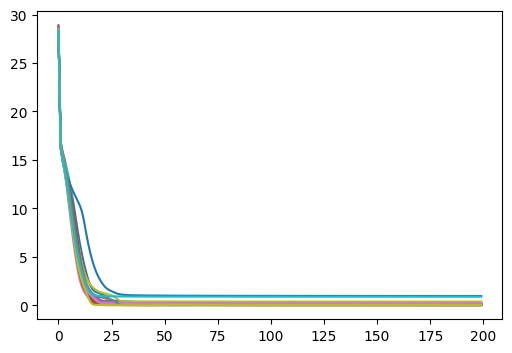

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in outputs:
    ax.plot(l[-1])

fig.show()

In [80]:
final_cost_scores = np.array([l[-1][-1] for l in outputs])

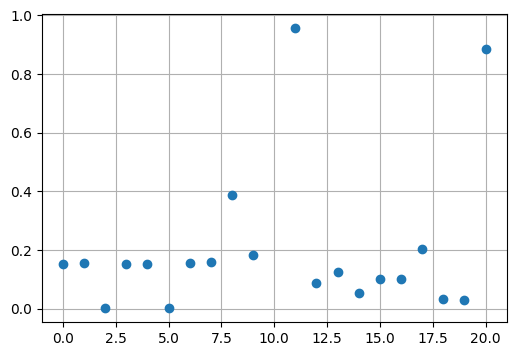

In [81]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_cost_scores, 'o')

ax.grid()

## Unitarity

In [70]:
sweep_overall_unitarity_scores = [l[2] for l in outputs]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3585287231.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


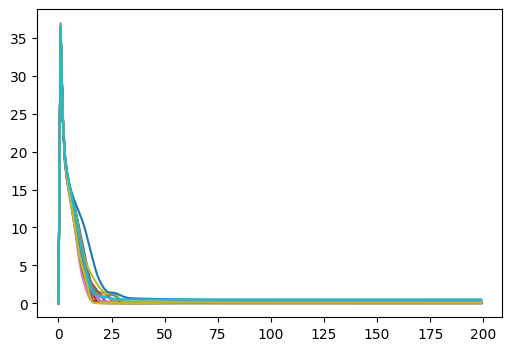

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in sweep_overall_unitarity_scores:
    ax.plot(l)

fig.show()

In [72]:
final_unitarity_scores = np.array([l[-1] for l in sweep_overall_unitarity_scores])

In [73]:
b_values = np.array(list(range(0,10)) + list(range(11, 21)))

In [74]:
len(b_values)

20

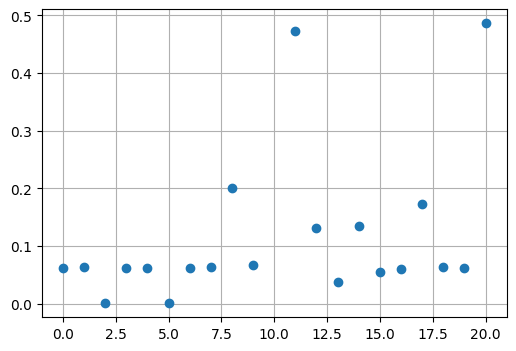

In [77]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_unitarity_scores, 'o')

ax.grid()

## Overlap scores

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/130678081.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


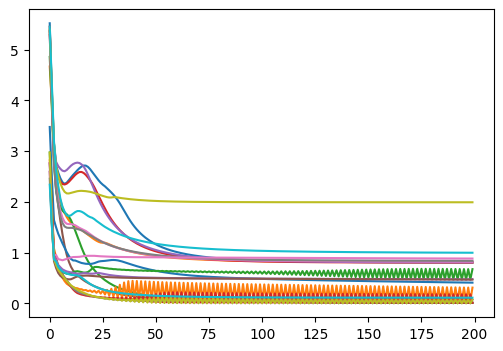

In [82]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in outputs:
    ax.plot(l[4])

fig.show()

In [84]:
final_overlap_scores = np.array([l[4][-1] for l in outputs])

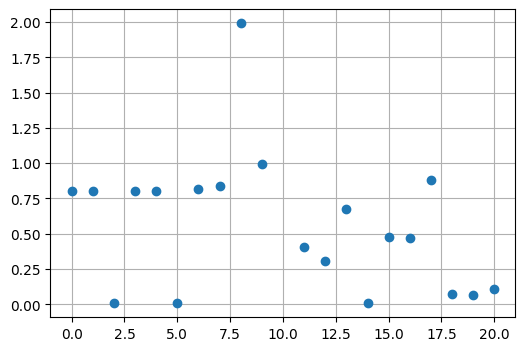

In [85]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_overlap_scores, 'o')

ax.grid()

## Proj rep scores

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/1324827603.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


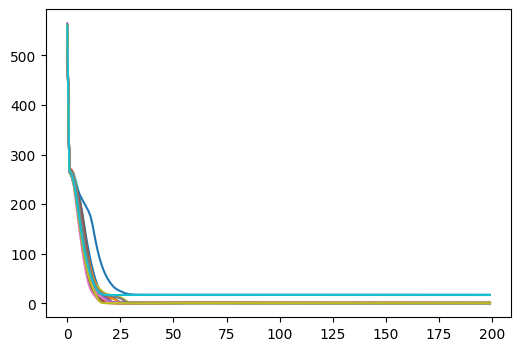

In [86]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in outputs:
    ax.plot(l[-2])

fig.show()

In [89]:
final_proj_rep_scores = np.array([l[-2][-1] for l in outputs])

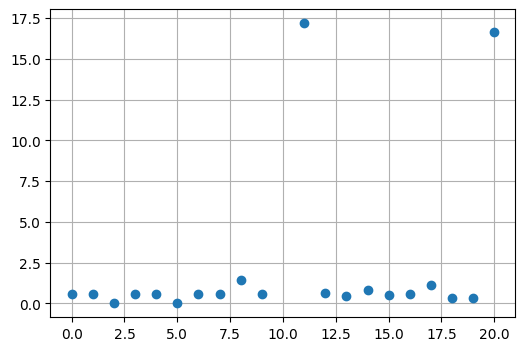

In [90]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_proj_rep_scores, 'o')

ax.grid()

# Sweep 2

In [92]:
num_sites = 4
num_random_initializations = 500
num_gd_iterations = 50

unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

In [93]:
four_site_outputs = list()

for i, l in enumerate(cases):
    print(i)
    outputs.append(proj_rep_unitary_extraction(l[1:]))

0
1
2
3
4
5
6
7
8
9
10


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/2324502288.py:31: RuntimeWarning: overflow encountered in scalar power
  (overlap_targets[l] - np.abs(current_overlaps[l]))**2
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:1761: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3393388920.py:21: RuntimeWarning: invalid value encountered in scalar divide
  c_normed = c/(np.abs(c))
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3515715503.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  get_u_score = lambda t: (t[2] - 2*t[1] + matrix_dim).real
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3515715503.py:10: RuntimeWarning: overflow encountered in scalar multiply
  get_u_score = lambda t: (t[2] - 2*t[1] + matr

11
12
13
14
15
16
17
18
19
20


In [94]:
len(outputs)

41

In [97]:
four_site_outputs = outputs[20:]

In [67]:
more_outputs = list()

for l in cases[11:]:
    outputs.append(proj_rep_unitary_extraction(l[1:]))

In [69]:
len(outputs)

20

## Analysis

### Loss function

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/766442944.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


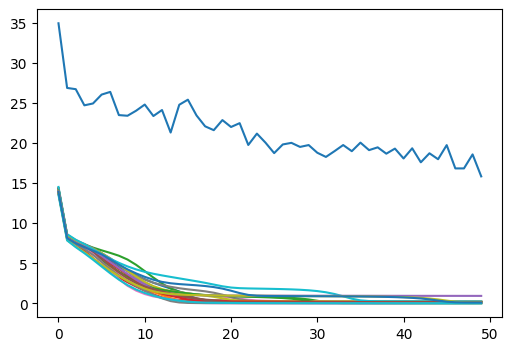

In [99]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in four_site_outputs:
    ax.plot(l[-1])

fig.show()

In [100]:
final_cost_scores = np.array([l[-1][-1] for l in four_site_outputs])

In [102]:
b_values = np.array(list(range(21)))/10

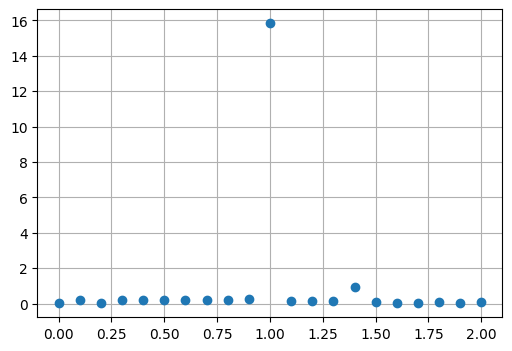

In [103]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_cost_scores, 'o')

ax.grid()

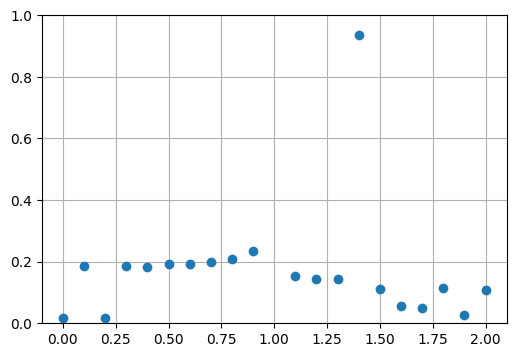

In [105]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_cost_scores, 'o')

ax.set_ylim(0, 1)

ax.grid()

## Unitarity

In [106]:
sweep_overall_unitarity_scores = [l[2] for l in four_site_outputs]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3585287231.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


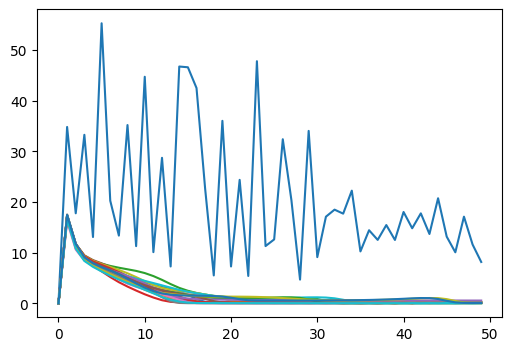

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in sweep_overall_unitarity_scores:
    ax.plot(l)

fig.show()

In [108]:
final_unitarity_scores = np.array([l[-1] for l in sweep_overall_unitarity_scores])

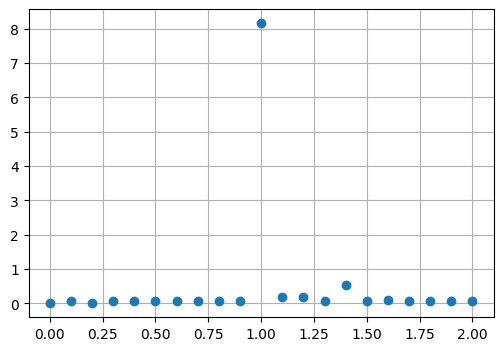

In [109]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_unitarity_scores, 'o')

ax.grid()

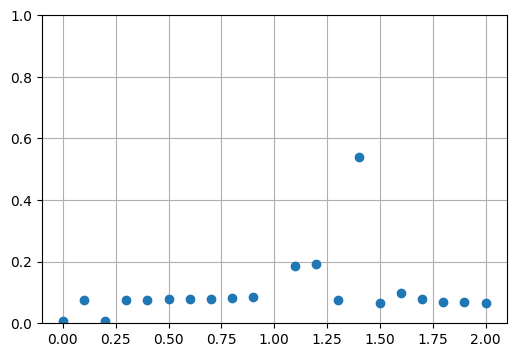

In [110]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_unitarity_scores, 'o')

ax.set_ylim(0,1)
ax.grid()

## Overlap scores

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/2811206054.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


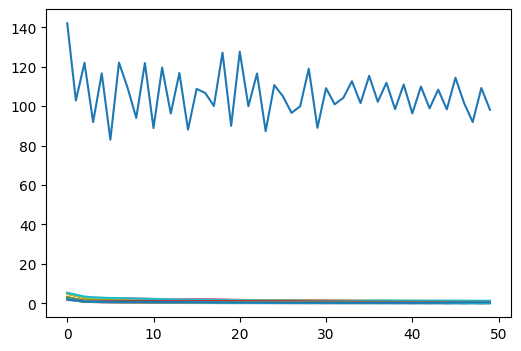

In [111]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in four_site_outputs:
    ax.plot(l[4])

fig.show()

In [112]:
final_overlap_scores = np.array([l[4][-1] for l in four_site_outputs])

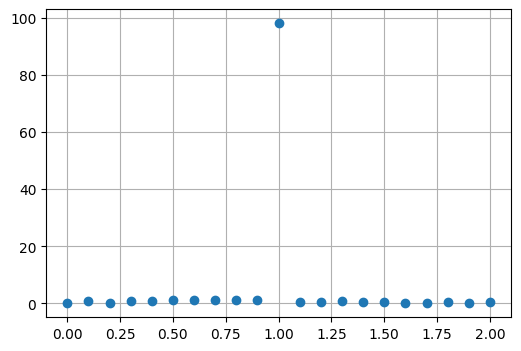

In [113]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_overlap_scores, 'o')

ax.grid()

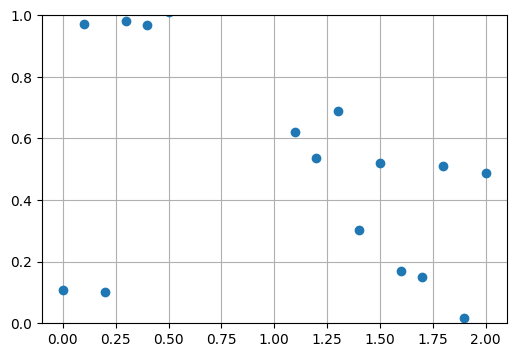

In [114]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_overlap_scores, 'o')

ax.set_ylim(0,1)

ax.grid()

## Proj rep scores

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_6161/3287020509.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


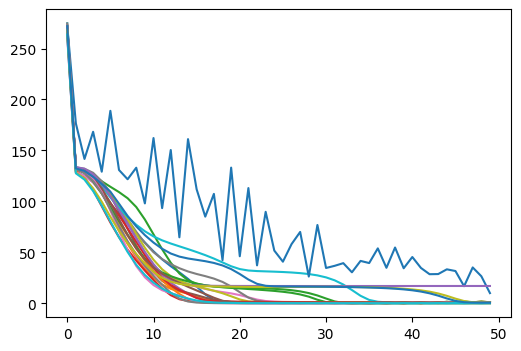

In [115]:
fig, ax = plt.subplots(figsize=(6, 4))

for l in four_site_outputs:
    ax.plot(l[-2])

fig.show()

In [117]:
final_proj_rep_scores = np.array([l[-2][-1] for l in four_site_outputs])

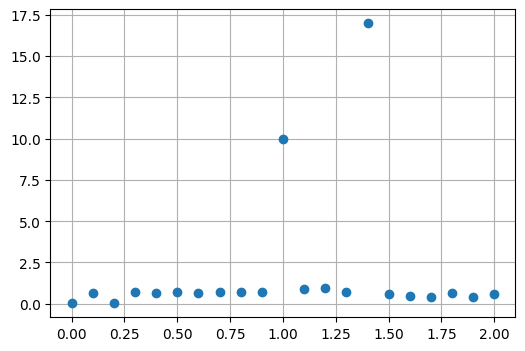

In [118]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_proj_rep_scores, 'o')

ax.grid()

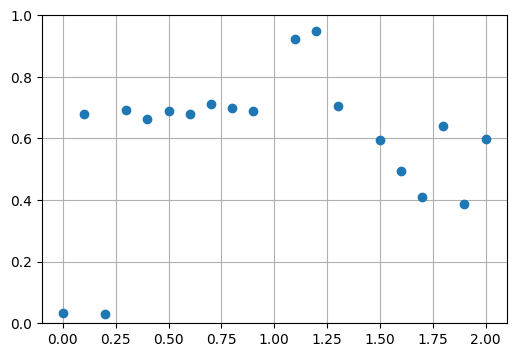

In [119]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(b_values, final_proj_rep_scores, 'o')

ax.set_ylim(0,1)

ax.grid()

# Extract SPT phase

In [121]:
unitaries = four_site_outputs[0][0]

In [122]:
unitaries

{'IX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XI': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>}

In [123]:
def extract_proj_rep_phase_generic(u_a, u_b, u_c, leg_label, leg_conj_label):
    u1 = npc.tensordot(u_a, u_b, [[leg_label,], [leg_conj_label,]])
    tr = npc.tensordot(
        u1,
        u_c.conj(),
        [
            [leg_label, leg_conj_label],
            [leg_conj_label, leg_label]
        ]
    )

    dim = u1.shape[0]

    return tr/dim

In [125]:
extract_proj_rep_phase_generic(*unitaries.values(), '(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)')

(0.885154896533797+0.4809537944847054j)

In [124]:
def extract_proj_rep_phase_inverse_pair(u_a, u_b, leg_label, leg_conj_label):
    tr = npc.tensordot(
        u_a,
        u_b,
        [
            [leg_label, leg_conj_label],
            [leg_conj_label, leg_label]
        ]
    )

    dim = u_a.shape[0]

    return tr/dim

In [126]:
extract_proj_rep_phase_inverse_pair(unitaries['XI'], unitaries['XI'], '(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)')

(0.9983555901350853+0.10233135998249612j)

In [127]:
group_products

[('IX', 'IX', 'II'),
 ('XI', 'XI', 'II'),
 ('XX', 'XX', 'II'),
 ('IX', 'XI', 'XX'),
 ('XI', 'IX', 'XX'),
 ('IX', 'XX', 'XI'),
 ('XX', 'IX', 'XI'),
 ('XX', 'XI', 'IX'),
 ('XI', 'XX', 'IX')]

In [128]:
def extract_proj_rep_phase(unitary_dict, group_label_triple, leg_label,
                           leg_conj_label):

    u_a, u_b, u_c = [
        get_unitary_from_dict(unitary_dict, l)
        for l in group_label_triple
    ]

    if u_c is None:
        return extract_proj_rep_phase_inverse_pair(
            u_a, u_b, leg_label, leg_conj_label
        )
    else:
        return extract_proj_rep_phase_generic(
            u_a, u_b, u_c, leg_label, leg_conj_label
        )

In [129]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        unitaries,
        triple,
        '(p0.p1.p2.p3)',
        '(p0*.p1*.p2*.p3*)'
    )
    for triple in group_products
}

In [130]:
proj_rep_phases

{('IX', 'IX', 'II'): (-0.9903161816390463+0.17364816682717998j),
 ('XI', 'XI', 'II'): (0.9983555901350853+0.10233135998249612j),
 ('XX', 'XX', 'II'): (0.4856028862703506-0.8807030235689112j),
 ('IX', 'XI', 'XX'): (0.885154896533797+0.4809537944847054j),
 ('XI', 'IX', 'XX'): (-0.8851549793370314-0.48095383658284824j),
 ('IX', 'XX', 'XI'): (-0.7887871920049185+0.6266024452935122j),
 ('XX', 'IX', 'XI'): (0.788787176493026-0.6266024296992687j),
 ('XX', 'XI', 'IX'): (0.9295821631451043-0.3881916031902815j),
 ('XI', 'XX', 'IX'): (-0.9295822722629381+0.38819164594875755j)}

In [132]:
from itertools import combinations

In [146]:
non_trivial_pairs = list(combinations(symmetry_labels[1:], 2))

In [136]:
l = list(range(10))

In [137]:
l[:1]

[0]

In [140]:
l[1::-1]

[1, 0]

In [143]:
def first_pair_agree(triple, pair):
    if triple[:2] == pair:
        return True
    elif triple[1::-1] == pair:
        return True
    else:
        return False

def get_gauge_invariant_phase(phase_dict, group_label_pair):
    phases = [
        v
        for k, v in phase_dict.items()
        if first_pair_agree(k, group_label_pair)
    ]

    assert len(phases) == 2

    return phases[1]/phases[0]

In [145]:
[
    get_gauge_invariant_phase(proj_rep_phases, pair)
    for pair in combinations(symmetry_labels[1:], 2)
]

[(-1.0000000921753043+2.5237610533018894e-09j),
 (-0.9999999783143189-2.5430718917556325e-09j),
 (-1.000000116309268-2.5729895133568068e-09j)]

In [154]:
sweep_phases = list()

for l in four_site_outputs:
    unitaries = l[0]

    proj_rep_phases = {
        triple: extract_proj_rep_phase(
            unitaries,
            triple,
            '(p0.p1.p2.p3)',
            '(p0*.p1*.p2*.p3*)'
        )
        for triple in group_products
    }

    phases = [
        get_gauge_invariant_phase(proj_rep_phases, pair)
        for pair in non_trivial_pairs
    ]

    sweep_phases.append(phases)

In [155]:
np.round(np.array(sweep_phases), 5)

array([[-1.     +0.000e+00j, -1.     -0.000e+00j, -1.     -0.000e+00j],
       [ 0.99999-4.230e-03j,  0.99999+4.230e-03j,  0.99999+4.230e-03j],
       [-1.     +0.000e+00j, -1.     -0.000e+00j, -1.     -0.000e+00j],
       [ 0.99999+4.260e-03j,  0.99999-4.260e-03j,  0.99999-4.260e-03j],
       [ 0.99999+4.160e-03j,  0.99999-4.160e-03j,  0.99999-4.160e-03j],
       [ 0.99999+4.230e-03j,  0.99999-4.230e-03j,  0.99999-4.230e-03j],
       [ 0.99999+4.200e-03j,  0.99999-4.200e-03j,  0.99999-4.200e-03j],
       [ 0.99999-4.290e-03j,  0.99999+4.290e-03j,  0.99999+4.290e-03j],
       [ 0.99999-4.260e-03j,  0.99999+4.260e-03j,  0.99999+4.260e-03j],
       [ 0.99999-4.160e-03j,  0.99999+4.160e-03j,  0.99999+4.160e-03j],
       [-1.00403-2.590e-03j, -1.00373+2.770e-03j, -1.00085+2.680e-03j],
       [ 1.     -0.000e+00j,  1.     +0.000e+00j,  1.     +0.000e+00j],
       [ 1.     +1.000e-05j,  1.     -1.000e-05j,  1.     -1.000e-05j],
       [-0.99999+4.840e-03j, -0.99999-4.840e-03j, -0.99999-4.840

In [156]:
five_site_sweep_phases = list()

for l in outputs[:20]:
    unitaries = l[0]

    proj_rep_phases = {
        triple: extract_proj_rep_phase(
            unitaries,
            triple,
            '(p0.p1.p2.p3.p4)',
            '(p0*.p1*.p2*.p3*.p4*)'
        )
        for triple in group_products
    }

    phases = [
        get_gauge_invariant_phase(proj_rep_phases, pair)
        for pair in non_trivial_pairs
    ]

    five_site_sweep_phases.append(phases)

In [157]:
np.round(np.array(sweep_phases), 5)

array([[-1.     +0.000e+00j, -1.     -0.000e+00j, -1.     -0.000e+00j],
       [ 0.99999-4.230e-03j,  0.99999+4.230e-03j,  0.99999+4.230e-03j],
       [-1.     +0.000e+00j, -1.     -0.000e+00j, -1.     -0.000e+00j],
       [ 0.99999+4.260e-03j,  0.99999-4.260e-03j,  0.99999-4.260e-03j],
       [ 0.99999+4.160e-03j,  0.99999-4.160e-03j,  0.99999-4.160e-03j],
       [ 0.99999+4.230e-03j,  0.99999-4.230e-03j,  0.99999-4.230e-03j],
       [ 0.99999+4.200e-03j,  0.99999-4.200e-03j,  0.99999-4.200e-03j],
       [ 0.99999-4.290e-03j,  0.99999+4.290e-03j,  0.99999+4.290e-03j],
       [ 0.99999-4.260e-03j,  0.99999+4.260e-03j,  0.99999+4.260e-03j],
       [ 0.99999-4.160e-03j,  0.99999+4.160e-03j,  0.99999+4.160e-03j],
       [-1.00403-2.590e-03j, -1.00373+2.770e-03j, -1.00085+2.680e-03j],
       [ 1.     -0.000e+00j,  1.     +0.000e+00j,  1.     +0.000e+00j],
       [ 1.     +1.000e-05j,  1.     -1.000e-05j,  1.     -1.000e-05j],
       [-0.99999+4.840e-03j, -0.99999-4.840e-03j, -0.99999-4.840

## Debug B=0.1 case

In [169]:
unitaries = four_site_outputs[1][0]

In [170]:
unitaries

{'IX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XI': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>}

In [171]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        unitaries,
        triple,
        '(p0.p1.p2.p3)',
        '(p0*.p1*.p2*.p3*)'
    )
    for triple in group_products
}

In [172]:
proj_rep_phases

{('IX', 'IX', 'II'): (0.33900719978165506+0.9500958087746607j),
 ('XI', 'XI', 'II'): (-1.0078680314099842-0.04072518773885056j),
 ('XX', 'XX', 'II'): (-0.07247587687894991-1.0060435451573393j),
 ('IX', 'XI', 'XX'): (-1.003656807407037+0.1139994595245941j),
 ('XI', 'IX', 'XX'): (-1.0031656338214037+0.11824240247511512j),
 ('IX', 'XX', 'XI'): (-0.2299224338931341-0.9835948361645799j),
 ('XX', 'IX', 'XI'): (-0.22576114300151223-0.984557812222873j),
 ('XX', 'XI', 'IX'): (0.9982350731532358+0.15443134139454048j),
 ('XI', 'XX', 'IX'): (0.9975734507536353+0.1586510198744018j)}

In [173]:
u = reduce(
    multiply_tensors,
    [
        unitaries['IX'],
        unitaries['XI'],
        unitaries['IX'].conj(),
        unitaries['XI'].conj()
    ]
)
npc.trace(u)/16

(1.0127641409906216-1.1054510677503682e-08j)

Doesn't look like a glitch, it's the wrong projective rep.

In [174]:
rdm = get_reduced_density_matrix(cases[1][0], 4)

In [179]:
symmetry_labels

['II', 'IX', 'XI', 'XX']

In [181]:
rdm = get_reduced_density_matrix(cases[1][1], 4)

np.abs(npc.tensordot(
    rdm,
    unitaries['IX'],
    [rdm.get_leg_labels(), rdm.get_leg_labels()[::-1]]
))

0.8514348590072386

In [183]:
rdm = get_reduced_density_matrix(cases[1][2], 4)

np.abs(npc.tensordot(
    rdm,
    unitaries['XI'],
    [rdm.get_leg_labels(), rdm.get_leg_labels()[::-1]]
))

0.8496526997092654

In [185]:
rdm = get_reduced_density_matrix(cases[1][3], 4)

np.abs(npc.tensordot(
    rdm,
    unitaries['XX'],
    [rdm.get_leg_labels(), rdm.get_leg_labels()[::-1]]
))

0.8407669390196789

In [162]:
unitaries = four_site_outputs[0][0]

In [163]:
unitaries

{'IX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XI': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>}

In [164]:
proj_rep_phases = {
    triple: extract_proj_rep_phase(
        unitaries,
        triple,
        '(p0.p1.p2.p3)',
        '(p0*.p1*.p2*.p3*)'
    )
    for triple in group_products
}

In [165]:
proj_rep_phases

{('IX', 'IX', 'II'): (-0.9903161816390463+0.17364816682717998j),
 ('XI', 'XI', 'II'): (0.9983555901350853+0.10233135998249612j),
 ('XX', 'XX', 'II'): (0.4856028862703506-0.8807030235689112j),
 ('IX', 'XI', 'XX'): (0.885154896533797+0.4809537944847054j),
 ('XI', 'IX', 'XX'): (-0.8851549793370314-0.48095383658284824j),
 ('IX', 'XX', 'XI'): (-0.7887871920049185+0.6266024452935122j),
 ('XX', 'IX', 'XI'): (0.788787176493026-0.6266024296992687j),
 ('XX', 'XI', 'IX'): (0.9295821631451043-0.3881916031902815j),
 ('XI', 'XX', 'IX'): (-0.9295822722629381+0.38819164594875755j)}

In [166]:
def multiply_tensors(u1, u2):
    return multiply_tenpy_matrices(
        u1, u2, '(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)'
    )

In [168]:
u = reduce(
    multiply_tensors,
    [
        unitaries['IX'],
        unitaries['XI'],
        unitaries['IX'].conj(),
        unitaries['XI'].conj()
    ]
)
npc.trace(u)/16

(-1.0090632466414535+2.5369595530247424e-11j)

# Conclusions
* This works, but is proving a pain in the neck to converge even for these simple cases.
    * Often converges to the _wrong_ projective rep, leading to the wrong SPT phase!
* The hyperparameters between the 3 costs seems to be an issue. Need to spend more effort tuning those (or sampling from a distribution?)
* Alternative GD algorithms could help.
* However the simpler method by extracting the phase from the state is
    * Faster
    * Easier
    * More accurate
* So maybe just work with the other one?